**USING RESNET18 WITH AND WITHOUT PRETRAINED WEIGHTS**

**LOADING THE SSL MODEL AND TRAINING A CLASSIFIER ON TOP OF IT**

Reference 1: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

Reference 2: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__

        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)

    except NameError:
        return False      # Probably standard Python interpreter

In [2]:
# if is_notebook():
#     %load_ext pycodestyle_magic

In [3]:
# if is_notebook():
#     %pycodestyle_on

***

***

# Imports

## Libraries and modules

In [4]:
# Custom modules.
from utils.computation import Experiment, pca_computation, tsne_computation
from utils.dataset import load_dataset_based_on_ratio

# OS module.
import os

# PyTorch.
import torch
import torchvision
from torchvision import datasets, models, transforms
from torchinfo import summary

# Data management.
import numpy as np

# import lightly

# Training checks.
from datetime import datetime
import copy
import time
import math

# import random

# For plotting.
import matplotlib.pyplot as plt

# Showing images in the notebook.
from IPython.display import Image
from IPython.core.display import HTML

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter

## Parser

In [5]:
# Workaround to make bool options work as expected.
def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

In [6]:
# Parser (get arguments).
if __name__ == '__main__':
    import argparse
    import sys
    parser = argparse.ArgumentParser(
        description=("Script for evaluating the self-supervised learning"
                     " models and compare them to standard approaches.")
    )
    parser.add_argument(
        '--dataset',
        type=str,
        default='Sentinel2GlobalLULC',
        choices=['Sentinel2GlobalLULC', 'Sentinel2AndaluciaLULC'],
        help='Dataset name for evaluation.'
    )
    parser.add_argument(
        '--ratio',
        type=str,
        default='(0.700,0.0900,0.2100)',
        help='Dataset ratio for evaluation.'
    )
    parser.add_argument(
        '--epochs',
        type=int,
        default=15,
        help='Number of epochs for training.'
    )
    parser.add_argument(
        '--batch_size',
        type=int,
        default=64,
        help='Number of images in a batch during training.'
    )
    parser.add_argument(
        '--show_fig',
        type=str2bool,
        default=True,
        help='Whether the images should appear.'
    )
    parser.add_argument(
        '--cluster',
        type=str2bool,
        default=False,
        help=('Whether the script runs on a cluster '
              '(large memory space available).')
    )

if is_notebook():
    args = parser.parse_args(
        args=['--dataset',
              'Sentinel2AndaluciaLULC',
              '--ratio',
              '(0.700,0.0900,0.2100)',
              '--batch_size',
              '16'])
else:
    args = parser.parse_args(sys.argv[1:])

## Settings

In [7]:
# Target dataset name.
dataset_name = args.dataset
print(f'Target dataset name: {dataset_name}')

# Target dataset ratio.
dataset_ratio = args.ratio
print(f'Target dataset ratio: {dataset_ratio}')

# Setting number of epochs.
epochs = args.epochs
print(f'Number of epochs: {epochs}')

# Setting batch size.
batch_size = args.batch_size
print(f'Batch size: {batch_size}')

# Show figures.
show = args.show_fig
print(f'Showing figures: {show}')

# Supercomputer?.
cluster = args.cluster
print(f'\nExecution on cluster: {cluster}')

# Avoiding the runtimeError: Too many open files.
# Communication with the workers is no longer possible.
if is_notebook() or cluster:
    print(f'Execution on jupyter or cluster: '
          f'Torch sharing strategy set to file_system (default)')
    torch.multiprocessing.set_sharing_strategy('file_descriptor')
else:
    print(f'Execution on shell with few resources: '
          'Torch sharing strategy set to file_system')
    torch.multiprocessing.set_sharing_strategy('file_system')

Target dataset name: Sentinel2AndaluciaLULC
Target dataset ratio: (0.700,0.0900,0.2100)
Number of epochs: 15
Batch size: 16
Showing figures: True

Execution on cluster: False
Execution on jupyter or cluster: Torch sharing strategy set to file_system (default)


In [8]:
# Hyperparamenters.
exp = Experiment(epochs=epochs,
                 batch_size=batch_size)
print(f'\nDevice: {exp.device}\n')

# Get current directory.
cwd = os.getcwd()
print(f'Working directory: {cwd}')

# Input directory where the datasets are stored.
input_dir_datasets = os.path.join(cwd, 'datasets')
print(f'\nInput directory for datasets: {input_dir_datasets}')

# Output directory.
output_dir = os.path.join(cwd, 'output')

# Output directory to save the model checkpoint.
output_dir_models = os.path.join(os.path.join(output_dir, 'pytorch_models'),
                                 'finetuning')
print(f'Output directory for model checkpoints: {output_dir_models}')

# Folder to save the figures.
output_dir_figs = os.path.join(os.path.join(output_dir, 'figures'),
                               'finetuning')
fig_format = '.png'  # .pdf
print(f'Output directory for figures ({fig_format} format): {output_dir_figs}')


Device: cuda

Working directory: /home/sfandres/Documents/Git/lulc

Input directory for datasets: /home/sfandres/Documents/Git/lulc/datasets
Output directory for model checkpoints: /home/sfandres/Documents/Git/lulc/output/pytorch_models/finetuning
Output directory for figures (.png format): /home/sfandres/Documents/Git/lulc/output/figures/finetuning


## Reproducibility

In [9]:
exp.reproducibility()

***

***

# Custom dataset

In [10]:
from torch.utils.data import Dataset, DataLoader
import torch
import os
import pandas as pd
from PIL import Image

class AndaluciaDataset(Dataset):
    """Sentinel2AndaluciaLULC dataset."""

    def __init__(self, root_dir, level, split, transform=None, target_transform=None):
        """
        Args:
            root_dir (str): Root (parent) directory.
            level (str): Level of the dataset (N1 or N2).
            split (str): Train, validation or test splits.
            transform (callable, optional): Optional transform to be
            applied on an image.
            target_transform (callable, optional): Optional transform to be
            applied on a label.
        """
        # Build paths.
        self.root_dir = root_dir
        self.level_dir = os.path.join(self.root_dir, level)
        self.images_dir = os.path.join(self.level_dir,
                                       os.path.join('RGB Images', split))

        # Get csv file.
        self.csv_file_path = os.path.join(self.level_dir,
                                          os.path.join('CSV',
                                                       f'csv_{split}.csv'))
        self.csv_dataset_info = pd.read_csv(self.csv_file_path)

        # Get transforms if applicable.
        self.transform = transform
        self.target_transform = target_transform

        # Get classes and mapping.
        classes = self._find_classes(level)
        self.classes, self.class_to_idx, self.idx_to_class = classes

        # Print info.
        self._show_info()

    def _show_info(self):
        """ Shows data regarding the dataset. """
        print('-----------Andalucia dataset info-----------')
        print(f'Root/Parent folder: {self.root_dir}')
        print(f'Level folder:       {self.level_dir}')
        print(f'Images folder:      {self.images_dir}')
        print(f'Path to csv file:   {self.csv_file_path}')
        print('Instance variables: .classes, .class_to_idx, .idx_to_class')
        print(f'Number of samples:  {self.__len__()}')
        print(f'Number of classes:  {len(self.classes)}')
        print('Labels:')
        print(self.classes)
        print(f'--------------------------------------------\n')

    def _find_classes(self, level):
        """
        Finds the class folders in a dataset.
        Args:
            level (str): Level of the dataset (N1 or N2).
        Returns:
            tuple: (classes, class_to_idx, idx_to_class) where classes are
            relative to (dir), and class_to_idx and idx_to_class are dictionaries.
        """
        # Get csv with class names.
        path_to_csv_dict = os.path.join(self.root_dir,
                                        'N1_and_N2_Dictionnary.xlsx')
        csv_dict = pd.read_excel(path_to_csv_dict, header=None)

        # Get the classes.
        if level == 'Level_N1':
            classes = csv_dict.iloc[2:6, 1].to_numpy()
        elif level == 'Level_N2':
            classes = csv_dict.iloc[10:21, 1].to_numpy()

        # Create the dictionaries.
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        idx_to_class = {v: k for k, v in class_to_idx.items()}

        return classes, class_to_idx, idx_to_class

    def __len__(self):
        """ Returns the number of samples. """
        return len(self.csv_dataset_info)

    def __getitem__(self, idx):
        """
        Supports the indexing of samples.
        Args:
            idx (int): index of the sample.
        Returns:
            sample (dict): sample returned.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get image name (with idx and column 'filename').
        img_name = os.path.join(self.images_dir,
                                self.csv_dataset_info.iloc[idx, 3])

        # Load image.
        img = Image.open(img_name)

        # Get ground-truth abundances (multi-label).
        abundances = self.csv_dataset_info.iloc[idx, 5:15]
        abundances = torch.FloatTensor(abundances)

        # Apply transforms if requested.
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            abundances = self.target_transform(abundances)

        return img, abundances

In [11]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [12]:
# Load Andalucia dataset.
andalucia_dataset = AndaluciaDataset(
    root_dir=os.path.join(input_dir_datasets, dataset_name),
    level='Level_N2',
    split='train',
    transform=transform,
    target_transform=None
)

-----------Andalucia dataset info-----------
Root/Parent folder: /home/sfandres/Documents/Git/lulc/datasets/Sentinel2AndaluciaLULC
Level folder:       /home/sfandres/Documents/Git/lulc/datasets/Sentinel2AndaluciaLULC/Level_N2
Images folder:      /home/sfandres/Documents/Git/lulc/datasets/Sentinel2AndaluciaLULC/Level_N2/RGB Images/train
Path to csv file:   /home/sfandres/Documents/Git/lulc/datasets/Sentinel2AndaluciaLULC/Level_N2/CSV/csv_train.csv
Instance variables: .classes, .class_to_idx, .idx_to_class
Number of samples:  15038
Number of classes:  10
Labels:
['Artificial' 'Annual croplands' 'Greenhouses' 'Woody croplands'
 'Combinations of croplands and natural vegetation'
 'Grasslands and Grasslands with trees'
 'Shrubland and Shrublands with trees' 'Forests' 'Barelands' 'Wetlands']
--------------------------------------------



In [13]:
dataloader = DataLoader(andalucia_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0)

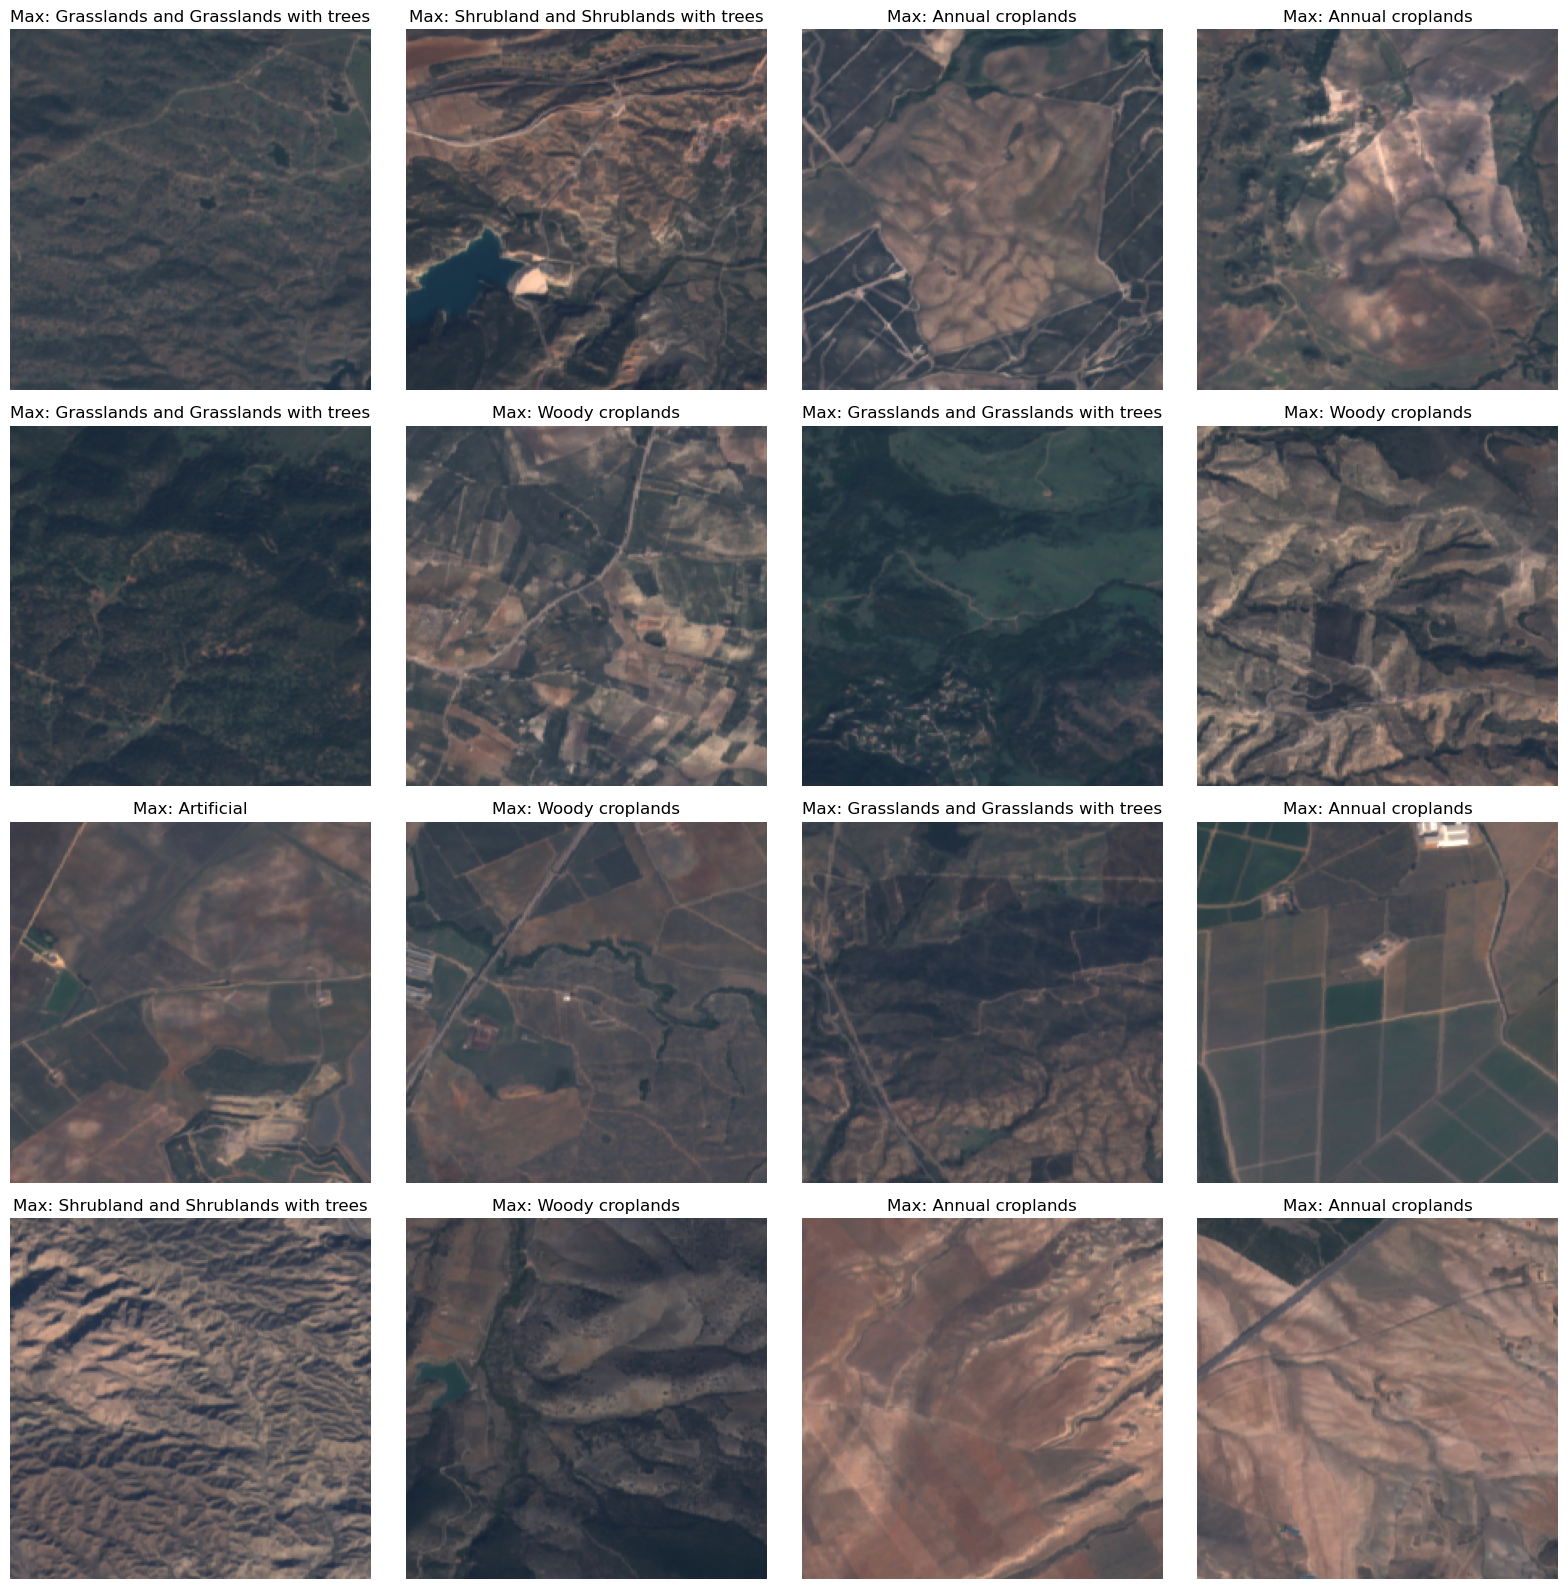

In [14]:
from utils.dataset import show_one_batch

# Create figure with subplots.
num_rows = int(dataloader.batch_size ** 0.5)
num_cols = (int(dataloader.batch_size / num_rows)
            + (dataloader.batch_size % num_rows > 0))
fig, axes = plt.subplots(nrows=num_rows,
                         ncols=num_cols,
                         figsize=(4*num_cols, 4*num_rows))
show_one_batch(axes, num_cols, dataloader,
               andalucia_dataset.idx_to_class, batch_id=0)
plt.tight_layout()
plt.show() if show else plt.close()

***

***

# Loading dataset

## Path and normalization values

In [ ]:
data_dir, mean, std = load_dataset_based_on_ratio(
    input_dir_datasets,
    dataset_name,
    dataset_ratio
)

## Load data

In [ ]:
# TO CREATE TWO TRANSFORMATIONS FOR THE SAME BATCH.
# class SSLDataTransform(object):
#     def __init__(self, transform):
#         self.transform = transform

#     def __call__(self, sample):
#         xi = self.transform(sample)
#         xj = self.transform(sample)
#         return (xi, xj)

In [ ]:
# Data augmentation.
data_transforms = {}
data_transforms['train'] = transforms.Compose([
    transforms.Resize((exp.input_size, exp.input_size)),
    transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean['train'], std['train'])
])

data_transforms['val'] = transforms.Compose([
    transforms.Resize((exp.input_size, exp.input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean['val'], std['val'])
])

data_transforms['test'] = transforms.Compose([
    transforms.Resize((exp.input_size, exp.input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean['test'], std['test'])
])

# ImageFolder.
splits = ['train', 'val', 'test']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in splits}

dataset_sizes = {x: len(image_datasets[x])
                 for x in splits}

# Dataloaders.
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=exp.batch_size,
                                              shuffle=True,
                                              drop_last=True,
                                              num_workers=exp.num_workers,
                                              worker_init_fn=exp.seed_worker,
                                              generator=exp.g)
               for x in splits}

# Get classes and number.
class_names = image_datasets['train'].classes
print(class_names)

***

***

UP TO HERE

***

***

## Check the balance and size of the dataset

In [ ]:
# Check samples per class in train dataset.
print(np.unique(train_data.targets, return_counts=True))

In [ ]:
# Check samples per class in test dataset.
print(np.unique(test_data.targets, return_counts=True))

In [ ]:
# Print some stats from the train dataset.
print(len(train_data.targets))

# Print some stats from the train dataloader.
print('N samples in train dataset: ' + str(len(dataloader_train.sampler)))
print('N samples in train dataset: ' + str(len(dataloader_train.dataset)))
print('N batches in train dataset: ' + str(len(dataloader_train)))

In [ ]:
# Print some stats from the val dataset.
print(len(val_data.targets))

# Print some stats from the val dataloader.
print('N samples in val dataset: ' + str(len(dataloader_val.dataset)))
print('N batches in val dataset: ' + str(len(dataloader_val)))

In [ ]:
# Print some stats from the test dataset.
print(len(test_data.targets))

# Print some stats from the test dataloader.
print('N samples in test dataset: ' + str(len(dataloader_test.dataset)))
print('N batches in test dataset: ' + str(len(dataloader_test)))

## Look at some samples

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(dataloader_train))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(torch.permute(img, (1, 2, 0)), cmap="gray")
plt.show()
print(f"Label: {class_names[label]}")

***

***

# Training loop

In [ ]:
# Training function.
def train_model(model, criterion, optimizer, device,
                epochs=10, save_best_model=False):
    """
    Main training function.

    """

    print(f"Using {exp.device} device")

    # Avoiding "CUDA out of memory" in PyTorch.
    torch.cuda.empty_cache()

    # Loss history.
    loss_values = {}
    loss_values['train'] = []
    loss_values['val'] = []
    total_time = 0

    # Saving best model's weights.
    best_model_val_wts = copy.deepcopy(model.state_dict())
    lowest_val_loss = 10000

    # Model to GPU if available.
    model.to(exp.device)

    # Iterating over the epochs.
    for epoch in range(epochs):

        # Initialize training loss.
        running_train_loss = 0.0

        # Start timer.
        since = time.time()

        # Enable training.
        model.train()

        for i, data in enumerate(dataloader_train):

            # Get the inputs; data is a list of [inputs, labels].
            inputs, labels = data[0].to(exp.device), data[1].to(exp.device)

            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward: make predictions.
            outputs = model(inputs)

            # Compute the loss and its gradients.
            loss = criterion(outputs, labels)
            loss.backward()

            # Averaged loss across all training examples * batch_size.
            running_train_loss += loss.item() * inputs.size(0)

            if i % 200 == 199:
                print(f'T[{epoch + 1}, {i + 1:5d}] | '
                      f'Running loss: '
                      f'{running_train_loss/(i*inputs.size(0)):.4f}')

            # Adjust learning weights.
            optimizer.step()

        # Loss averaged across all training examples for the current epoch.
        epoch_train_loss = running_train_loss / len(dataloader_train.sampler)

        # Change model to evaluation mode.
        model.eval()

        # Initialize validating loss.
        running_val_loss = 0.0
        with torch.no_grad():
            for j, vdata in enumerate(dataloader_val):

                # Get the inputs; data is a list of [inputs, labels].
                vinputs, vlabels = vdata[0].to(exp.device), vdata[1].to(exp.device)

                # Forward: make predictions.
                voutputs = model(vinputs)

                # Compute the loss (w/o gradients).
                vloss = criterion(voutputs, vlabels)

                # Averaged loss across all validating examples * batch_size.
                running_val_loss += vloss.item() * vinputs.size(0)

                if j % 50 == 49:
                    print(f'V[{epoch + 1}, {j + 1:5d}] | '
                          f'Running loss: '
                          f'{running_val_loss/(j*inputs.size(0)):.4f}')

        # Loss averaged across all validating examples for the current epoch.
        epoch_val_loss = running_val_loss / len(dataloader_val.sampler)

        # Append loss values.
        loss_values['train'].append(epoch_train_loss)
        loss_values['val'].append(epoch_val_loss)

        # Deep copy the weights of the model.
        save_weights = epoch_val_loss < lowest_val_loss
        if save_weights:
            lowest_val_loss = epoch_val_loss
            best_model_train_loss = epoch_train_loss
            best_model_val_wts = copy.deepcopy(model.state_dict())

        # End timer.
        time_elapsed = time.time() - since
        total_time += time_elapsed

        # Show stats.
        print(f'Epoch: {epoch} | '
              f'Train loss: {epoch_train_loss:.4f} | '
              f'Val loss: {epoch_val_loss:.4f} | '
              f'Elapsed: {time_elapsed // 60:.0f}m '
              f'{time_elapsed % 60:.0f}s | '
              f'Save weights: {save_weights}')

    print(f'\nTraining completed in {total_time // 60:.0f}m '
          f'{total_time % 60:.0f}s')

    # Load best model weights.
    model.load_state_dict(best_model_val_wts)

    if save_best_model:

        # Move to CPU before saving it.
        model.to('cpu')

        # Filename with stats.
        save_path = f'pytorch_models/resnet18' \
                    f'-losses={best_model_train_loss:.2f}' \
                    f'_{lowest_val_loss:.2f}' \
                    f'-time={datetime.now():%Y_%m_%d-%H_%M_%S}'

        # Save this pretrained model (recommended approach).
        torch.save(model.state_dict(), save_path)

        print('Model successfuly saved')

        # Move back to the GPU.
        model.to(exp.device)

    return model, loss_values

In [ ]:
def plot_losses(loss_history, title='', save_fig=False):
    """
    Function for plotting the training and validation losses

    """

    fig = plt.figure(figsize=(10, 5))
    plt.plot(loss_history['train'], label='Train')
    plt.plot(loss_history['val'], label='Validation')
    plt.xlabel('Epoch', labelpad=15)
    plt.ylabel('Loss', labelpad=15)
    plt.title(title)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.15)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    if save_fig:
        fig.savefig('plt_loss_values.pdf', bbox_inches='tight')

In [ ]:
def evaluation_on_test(model, device):
    """
    Function to evaluate the performance
    of the model on the test dataset.

    """

    # Avoiding "CUDA out of memory" in PyTorch.
    torch.cuda.empty_cache()

    correct = 0
    total = 0

    # Since we're not training, we don't need to calculate
    # the gradients for our outputs with torch.no_grad():
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(dataloader_test):

            # Dataset.
            inputs, labels = data[0].to(device), data[1].to(device)

            # Calculate outputs by running images through the network.
            outputs = model(inputs)

            # The class with the highest energy is what we
            # choose as prediction.
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Progress bar.
            if i % 50 == 49:
                print(f'Progress: {100 * i // len(dataloader_test)}%',
                      end='\r',
                      flush=True)

    print(f'Accuracy of the network on the {total} '
          f'test images: {100 * correct // total}%')

***

***

# ResNet18 from scrath

## Definition and hyperparameters

In [ ]:
# Model: resnet with random weights.
model = torchvision.models.resnet18(weights=None)

## Adjust final layer

Type: linear not softmax for the moment.

In [ ]:
# Check old final layer.
print(model.fc)

# Get the number of input features to the layer.
num_ftrs = model.fc.in_features
print(num_ftrs)

# Adjust the final layer to the current number of classes.
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

# Check new final layer.
print(model.fc)

# Freezing all the network except the final layer.
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Model structure.
summary(
    model,
    input_size=(exp.batch_size, 3, exp.input_size, exp.input_size),
    device=exp.device
)

## Loss fcn and optimizer

In [ ]:
# Loss function: cross-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers: specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01)

## Training

In [ ]:
model, loss_history = train_model(
    model,
    loss_fn,
    optimizer,
    exp.device,
    epochs=exp.epochs,
    save_best_model=True
)

plot_losses(loss_history, 'Model w/o pretrained weights')

## Check performance on test dataset

In [ ]:
evaluation_on_test(model, exp.device)

## F1-score

In [ ]:
# Confusion matrix
conf_mat, class_accuracy = utils.create_confusion_matrix(
    model,
    dataloader_test,
    exp.device,
    class_names
)

# Bar plot for accuracy values.
utils.simple_bar_plot(range(len(class_names)),
                      class_accuracy,
                      'Classes',
                      'Accuracy (%)',
                      'class_accuracy',
                      fig_size=(15, 5),
                      save=False)

***

***

# ResNet18 with pretrained weights

## Definition and hyperparameters

In [ ]:
# Model: resnet with pretrained weights.
del model
model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.DEFAULT
)

## Adjust final layer

In [ ]:
# Check old final layer.
print(model.fc)

# Get the number of input features to the layer.
num_ftrs = model.fc.in_features
print(num_ftrs)

# Adjust the final layer to the current number of classes.
model.fc = torch.nn.Linear(num_ftrs, len(class_names))

# Parameters of newly constructed modules
# have requires_grad=True by default.
# Check new final layer.
print(model.fc)

# Freezing all the network except the final layer.
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Model structure.
summary(
    model,
    input_size=(exp.batch_size, 3, exp.input_size, exp.input_size),
    device=exp.device
)

## Loss fcn and optimizer

In [ ]:
# Loss function: cross-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers: specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01)

## Training

In [ ]:
model, loss_history = train_model(
    model,
    loss_fn,
    optimizer,
    exp.device,
    epochs=exp.epochs,
    save_best_model=True
)

plot_losses(loss_history, 'Model w/ pretrained weights')

## Check performance on test dataset

In [ ]:
evaluation_on_test(model, exp.device)

## F1-score

In [ ]:
# Confusion matrix
conf_mat, class_accuracy = utils.create_confusion_matrix(
    model,
    dataloader_test,
    exp.device,
    class_names
)

# Bar plot for accuracy values.
utils.simple_bar_plot(range(len(class_names)),
                      class_accuracy,
                      'Classes',
                      'Accuracy (%)',
                      'class_accuracy',
                      fig_size=(15, 5),
                      save=False)

***

***

# SSL model

## Loading

In [ ]:
# State model class.
resnet18 = torchvision.models.resnet18(weights=None)

# Only backbone (w/o final fc layer).
pt_backbone = torch.nn.Sequential(*list(resnet18.children())[:-1])

In [ ]:
# List of trained models.
model_list = []
for root, dirs, files in os.walk('pytorch_models/history_log/'):
    for i, filename in enumerate(sorted(files, reverse=True)):
        model_list.append(root + filename)
        print(f'{i:02}: {filename}')

In [ ]:
# Loading model.
idx = 0
print(model_list[idx])
pt_backbone.load_state_dict(torch.load(model_list[idx]))

In [ ]:
# Check if the model is loaded on GPU.
next(pt_backbone.parameters()).is_cuda

## Checking the weights

In [ ]:
# First convolutional layer weights.
# print(backbone)
print(pt_backbone[0])
print(pt_backbone[0].weight[63])

## Adding a final linear layer

In [ ]:
# Adding a linear layer on top of the model (linear classifier).
model_ssl = torch.nn.Sequential(
    pt_backbone,
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=512, out_features=len(class_names), bias=True),
    # torch.nn.Softmax(dim=1)
)

# Freezing all the network except the final layer.
for param in model_ssl.parameters():
    param.requires_grad = False
# for param in model_ssl[0][7].parameters():
#     param.requires_grad = True
for param in model_ssl[2].parameters():
    param.requires_grad = True

# Model structure.
summary(
    model_ssl,
    input_size=(exp.batch_size, 3, exp.input_size, exp.input_size),
    device=exp.device
)

## Loss fcn and optimizer

In [ ]:
# Loss function: cross-entropy loss.
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizers: specified in the torch.optim package
optimizer = torch.optim.Adam(model_ssl.parameters(),
                             lr=0.01)

## Training

In [ ]:
model_ssl, loss_history = train_model(
    model_ssl,
    loss_fn,
    optimizer,
    exp.device,
    epochs=exp.epochs,
    save_best_model=True
)

plot_losses(loss_history, 'Model w/ ssl pretrained weights')

## Checking the weights after training

They should have remained the same (frozen) except for the final layer.

In [ ]:
# First convolutional layer weights.
# print(backbone)
print(pt_backbone[0])
print(pt_backbone[0].weight[63])

## Check performance on test dataset

In [ ]:
evaluation_on_test(model_ssl, exp.device)

## F1-score

In [ ]:
# Confusion matrix
conf_mat, class_accuracy = utils.create_confusion_matrix(
    model_ssl,
    dataloader_test,
    exp.device,
    class_names
)

# Bar plot for accuracy values.
utils.simple_bar_plot(range(len(class_names)),
                      class_accuracy,
                      'Classes',
                      'Accuracy (%)',
                      'class_accuracy',
                      fig_size=(15, 5),
                      save=False)

***

***